#### Import of the Packages

In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np
import session_info

# more packages
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
session_info.show()

##### Softmax activation for numpy

In [2]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=0)
x= np.array([2.0,1.0,0.1])
outputs= softmax(x)
print(f'softmax: {outputs}')

softmax: [0.65900114 0.24243297 0.09856589]


##### Softmax activation for pytorch

In [3]:
x= torch.tensor([2.0,1.0,0.1])
outputs= torch.softmax(x,dim=0)# already implement in torch
print(f'softmax_torch: {outputs}')

softmax_torch: tensor([0.6590, 0.2424, 0.0986])


##### For multiclass classification

In [4]:
# Cross-entropy loss is often associated with softmax activation for multiclass problems
#In numpy
def cross_entropy(true,predicted):
    loss = -np.sum(true *np.log(predicted))
    return loss # / float(predicted.shape[0]) ##if we want to normalize, we divide by the number of sample

Y= np.array([1,0,0]) # True value of Y as a one-hot encode result
y_pred_good =np.array([0.7,0.2,0.1])
y_pred_bad =np.array([0.2,0.3,0.5])
l1= cross_entropy(Y,y_pred_good)
l2= cross_entropy(Y,y_pred_bad)
print(f'Loss1 numpy: {l1:.2f}')
print(f'Loss2 numpy: {l2:.2f}')

Loss1 numpy: 0.36
Loss2 numpy: 1.61


In [5]:
# In pytorch for one sample
loss=nn.CrossEntropyLoss() #note that softmax is include in it, no need a softmax activation as last layer

Y= torch.tensor([0])# the good class is the first one

y_pred_good =torch.tensor([[2.0,1.0,0.1]])
y_pred_bad =torch.tensor([[0.6,2.0,0.2]])
l1= loss(y_pred_good,Y)
l2= loss(y_pred_bad,Y)

print(f'Loss1 torch: {l1.item():.2f}')
print(f'Loss2 torch: {l2.item():.2f}')

Loss1 torch: 0.42
Loss2 torch: 1.74


In [6]:
# In pytorch for multiple samples

Y= torch.tensor([2,0,1])

y_pred_good =torch.tensor([[0.5,1.0,2.0],[2.0,1.0,0.1],[1.0,2.0,0.1]])
y_pred_bad =torch.tensor([[0.6,2.0,0.2],[1.0,5.0,2.1],[0.6,2.0,0.2]])
l1= loss(y_pred_good,Y)
l2= loss(y_pred_bad,Y)

print(f'Loss1 torch: {l1.item():.2f}')
print(f'Loss2 torch: {l2.item():.2f}')

Loss1 torch: 0.43
Loss2 torch: 2.19


### Activation Function

In [7]:
# include in a create nn.Module(in the init def)
class NeuNet(nn.Module):
    def __init__(self,input_size,hidden_size):
        super(NeuNet,self).__init__()
        self.linear1= nn.Linear(input_size,hidden_size)
        self.relu= nn.ReLU()
        self.linear2= nn.Linear(hidden_size,1)
        self.sigmoid= nn.Sigmoid()
        
    def forward(self,inputs):
        x= self.linear1(inputs)
        x= self.relu(x)
        x= self.linear2(x)
        outputs= self.sigmoid(x)
        return outputs
        

In [8]:
# Put the activation only in the forward pass
class NeuNet_2(nn.Module):
    def __init__(self,input_size,hidden_size):
        super(NeuNet_2,self).__init__()
        self.linear1= nn.Linear(input_size,hidden_size)
        self.linear2= nn.Linear(hidden_size,1)
        
    def forward(self,inputs):
        x= torch.relu(self.linear1(inputs))
        outputs= torch.sigmoid(self.linear2(x))
        return outputs

### Implement a first neural network for MNIST  

In [9]:
# Use graphical card
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define hyperparameters
input_size= 28*28 # images of MNIST are under this format in gray(one channel)
hidden_size= 200
num_class = 10 # from 0 to 9
num_epochs=5
batch_size= 40
learning_rate = 0.001

In [10]:
data_train=torchvision.datasets.MNIST(root='/data',train=True, transform=transforms.ToTensor(),download=True)
data_test=torchvision.datasets.MNIST(root='/data',train=False, transform=transforms.ToTensor(),download=True)

In [11]:
loader_train= torch.utils.data.DataLoader(dataset= data_train,batch_size=batch_size, shuffle=True)
loader_test= torch.utils.data.DataLoader(dataset= data_test,batch_size=batch_size, shuffle=False)

torch.Size([40, 1, 28, 28])


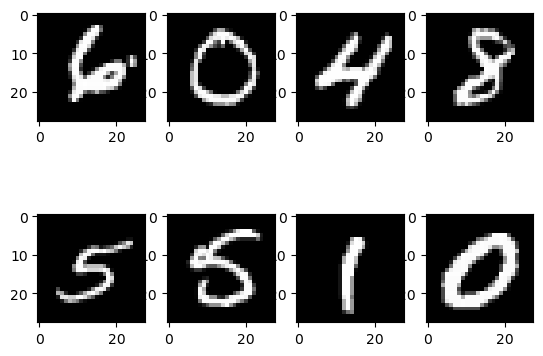

In [12]:
exemples= next(iter(loader_train))
data,target= exemples
print (data.shape)
for i in range(8):
    plt.subplot(2,4, i+1)
    plt.imshow(data[i][0], cmap='gray')
plt.show()

#### Model

In [13]:
class MNISTNet(nn.Module):
    def __init__(self,input_size,hidden_size, num_classes):
        super(MNISTNet,self).__init__()
        self.linear1= nn.Linear(input_size,hidden_size)
        self.linear2= nn.Linear(hidden_size,num_classes)
    def forward(self,inputs):
        x= torch.relu(self.linear1(inputs))
        outputs= self.linear2(x)
        # no softmax because Cross entropy Loss
        return outputs
model= MNISTNet(input_size,hidden_size,num_class).to(device)

#### Loss and Optimizer

In [14]:
criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr =learning_rate)

#### Training loop

In [15]:
#Train
for epoch in range(num_epochs):
    for i,(images,labels) in enumerate (loader_train):
        # first we reshape the image (40,1,28,28) to (40,728) and push it on the GPU
        image= images.reshape(-1,28*28).to(device)
        labels= labels.to(device)
        
        #forward
        outputs=model(image)
        loss= criterion(outputs,labels)
        
        #backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    print (f'epoch {epoch+1}/{num_epochs}, loss = {loss:.3f}')

epoch 1/5, loss = 0.347
epoch 2/5, loss = 0.111
epoch 3/5, loss = 0.048
epoch 4/5, loss = 0.057
epoch 5/5, loss = 0.075


In [16]:
# Test        
with torch.no_grad():
    n_correct=0
    n_samples=0
    for images, labels in loader_test:
        images= images.reshape(-1,28*28).to(device)
        labels= labels.to(device)
        outputs = model(images)

        # return value and index of the best class
        _,predictions= torch.max(outputs,1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    acc= 100 * n_correct /n_samples
    print(f'Accuracy= {acc:.1f}')

Accuracy= 97.7
